In [200]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from tqdm.auto import tqdm
import numpy as np
from transformers import BertTokenizer, BertModel

In [189]:
X_test = torch.load("X_test.pt")
X_train = torch.load("X_train.pt")
y_test = torch.load("y_test.pt")
y_train = torch.load("y_train.pt")

In [190]:
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
elif torch.mps.is_available():
    device = 'mps'
device

'mps'

In [191]:
class MyModel(nn.Module):
    def __init__(
        self,
        dataloader: DataLoader,
        input_dim: int,
        output_dim: int = 1,
        dropout_rate: float = 0.5,
    ):
        super(MyModel, self).__init__()
        self.dataloader = dataloader
        self.conv1d = nn.Conv1d(in_channels=input_dim, out_channels=384, kernel_size=3, stride=1, padding=2)
        self.maxpooling1d = nn.MaxPool1d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.relu = nn.ReLU()
        self.last_linear = nn.Linear(384, output_dim)
        self.sigmoid = nn.Sigmoid()

        self.to(device)

    def forward(self, x: torch.Tensor):
        if len(x.shape) == 2:  # Если x имеет размерность [batch_size, sequence_length]
            x = x.unsqueeze(1)  # Добавляем измерение каналов: [batch_size, 1, sequence_length]
        x = x.permute(0, 2, 1)  # [batch_size, input_dim, sequence_length]
        x = self.conv1d(x)
        x = self.maxpooling1d(x)
        x = self.dropout1(x)
        x = self.relu(x)
        x = x.permute(0, 2, 1)  # Возвращаем размерность [batch_size, sequence_length, features]
        x = self.last_linear(x)
        x = self.sigmoid(x)
        return x

    def fit(
        self,
        num_epoch: int = 10,
        lr: float = 1e-10,
    ):
        self.epoch_loss = []
        self.batch_loss = []
        self.f1_score = []
        self.all_labels = []
        self.all_probs = []
        criterion = nn.BCELoss()  # Бинарная кросс-энтропия
        optimizer = optim.Adam(self.parameters(), lr=lr)
        for epoch in range(num_epoch):
            self.train()
            epoch_losses = []
            for batch_X, batch_y in tqdm(self.dataloader, desc=f"Epoch [{epoch+1}/{num_epoch}]; learning state\t"):
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                optimizer.zero_grad()
                outputs = self(batch_X)
                loss: torch.Tensor = criterion(outputs.squeeze(1), batch_y.unsqueeze(1))
                loss.backward()
                optimizer.step()
                epoch_losses.append(loss.item())
                self.batch_loss.append(loss.item())
            
            self.epoch_loss.append(sum(epoch_losses) / len(epoch_losses))
            
            # Вычисление метрик
            self.eval()
            with torch.no_grad():
                self.all_preds = []
                self.all_labels = []
                for batch_X, batch_y in tqdm(self.dataloader, desc=f"Epoch [{epoch+1}/{num_epoch}]; metric state\t"):
                    batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                    outputs = self(batch_X).squeeze(1)
                    preds = (outputs > 0.5).float()
                    self.all_preds.extend(preds.squeeze(1).cpu().numpy())
                    self.all_labels.extend(batch_y.cpu().numpy())

                self.all_labels = np.array(self.all_labels, dtype=int)
                self.all_preds = np.array(self.all_preds, dtype=int)
                f1 = f1_score(self.all_labels, self.all_preds)
                self.f1_score.append(f1)
                print(f"Epoch [{epoch+1}/{num_epoch}], Loss: {loss.item():.4f}, F1 score: {f1:.5f}")
    
    def plot_metrics(self, X_test: torch.Tensor, y_test:torch.Tensor):
        plt.figure(figsize=(16, 5))
        plt.subplot(1, 3, 1)
        plt.plot(self.epoch_loss, label="Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Loss per Epoch")
        plt.legend()

        plt.subplot(1, 3, 2)
        plt.plot(self.batch_loss, label="Loss")
        plt.xlabel("Batches")
        plt.ylabel("Loss")
        plt.title("Loss per batch")
        plt.legend()

        # График F1-score
        plt.subplot(1, 3, 3)
        plt.plot(self.f1_score, label="F1-score", color="orange")
        plt.xlabel("Epoch")
        plt.ylabel("F1-score")
        plt.title("F1-score per Epoch")
        plt.legend()

        X_test = X_test.float()
        X_test = X_test.unsqueeze(1)
        X_test = X_test.to(device)
        self.eval()
        with torch.no_grad():
            preds = self(X_test)
        preds_squeezed = preds.squeeze(1).squeeze(1)
        result_pres = (preds_squeezed > 0.5).float()
        f1 = f1_score(y_test.numpy(), result_pres.cpu().numpy())
        print(f"F1 score on test tensors is: {f1*100:.2f}")

In [192]:
# не изменные константы для модельки
input_dim = X_train.shape[1]
output_dim = 1
dataset = TensorDataset(X_train, y_train.float())

Epoch [1/10]; metric state	: 100%|██████████| 6106/6106 [00:14<00:00, 420.99it/s]


Epoch [1/10], Loss: 0.7014, F1 score: 0.32971


Epoch [2/10]; metric state	: 100%|██████████| 6106/6106 [00:12<00:00, 503.82it/s]


Epoch [2/10], Loss: 0.7115, F1 score: 0.32973


Epoch [3/10]; metric state	: 100%|██████████| 6106/6106 [00:12<00:00, 493.22it/s]


Epoch [3/10], Loss: 0.7199, F1 score: 0.32975


Epoch [4/10]; metric state	: 100%|██████████| 6106/6106 [00:21<00:00, 281.88it/s]


Epoch [4/10], Loss: 0.7244, F1 score: 0.32976


Epoch [5/10]; metric state	: 100%|██████████| 6106/6106 [00:12<00:00, 504.92it/s]


Epoch [5/10], Loss: 0.6982, F1 score: 0.32977


Epoch [6/10]; metric state	: 100%|██████████| 6106/6106 [00:13<00:00, 466.64it/s]


Epoch [6/10], Loss: 0.7179, F1 score: 0.32978


Epoch [7/10]; metric state	: 100%|██████████| 6106/6106 [00:12<00:00, 506.14it/s]


Epoch [7/10], Loss: 0.7021, F1 score: 0.32980


Epoch [8/10]; metric state	: 100%|██████████| 6106/6106 [00:12<00:00, 505.10it/s]


Epoch [8/10], Loss: 0.7025, F1 score: 0.32983


Epoch [9/10]; metric state	: 100%|██████████| 6106/6106 [00:16<00:00, 365.11it/s]


Epoch [9/10], Loss: 0.7099, F1 score: 0.32985


Epoch [10/10]; metric state	: 100%|██████████| 6106/6106 [00:13<00:00, 455.90it/s]


Epoch [10/10], Loss: 0.7034, F1 score: 0.32987
F1 score on test tensors is: 32.35


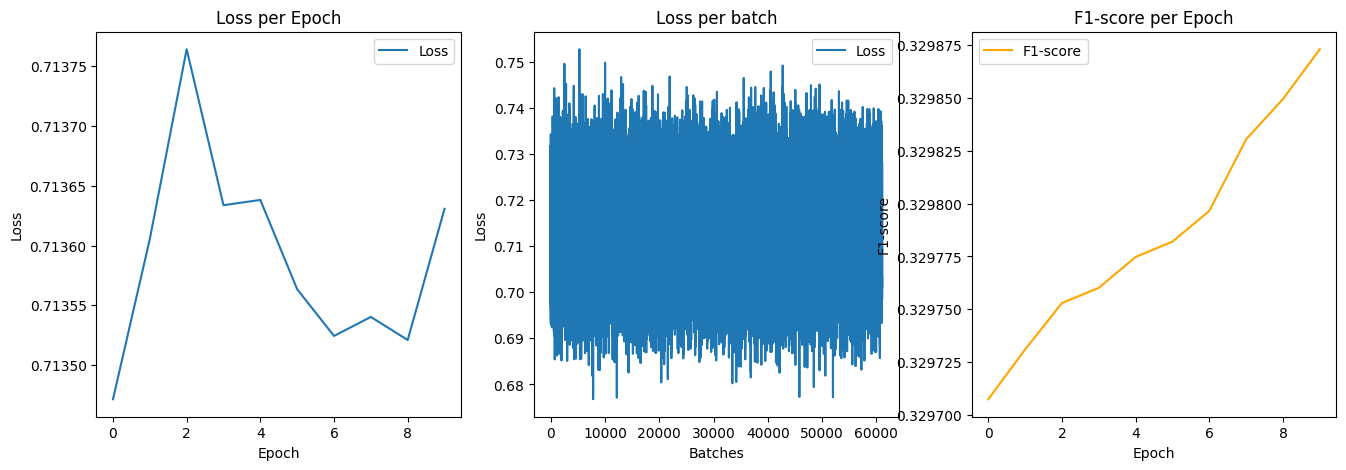

In [193]:
dropout_rate = 0.5
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
model = MyModel(dataloader, input_dim, output_dim, dropout_rate)
model.fit()
model.plot_metrics(X_test, y_test)

Epoch [1/10]; metric state	: 100%|██████████| 6106/6106 [00:12<00:00, 471.44it/s]


Epoch [1/10], Loss: 0.3351, F1 score: 0.77061


Epoch [2/10]; metric state	: 100%|██████████| 6106/6106 [00:12<00:00, 489.09it/s]


Epoch [2/10], Loss: 0.2134, F1 score: 0.79175


Epoch [3/10]; metric state	: 100%|██████████| 6106/6106 [00:20<00:00, 296.47it/s]


Epoch [3/10], Loss: 0.1048, F1 score: 0.80272


Epoch [4/10]; metric state	: 100%|██████████| 6106/6106 [00:20<00:00, 303.99it/s]


Epoch [4/10], Loss: 0.1831, F1 score: 0.82207


Epoch [5/10]; metric state	: 100%|██████████| 6106/6106 [00:11<00:00, 510.65it/s]


Epoch [5/10], Loss: 0.1980, F1 score: 0.83515


Epoch [6/10]; metric state	: 100%|██████████| 6106/6106 [00:12<00:00, 496.29it/s]


Epoch [6/10], Loss: 0.2085, F1 score: 0.84908


Epoch [7/10]; metric state	: 100%|██████████| 6106/6106 [00:19<00:00, 319.42it/s]


Epoch [7/10], Loss: 0.2314, F1 score: 0.85264


Epoch [8/10]; metric state	: 100%|██████████| 6106/6106 [00:14<00:00, 421.28it/s]


Epoch [8/10], Loss: 0.0662, F1 score: 0.86064


Epoch [9/10]; metric state	: 100%|██████████| 6106/6106 [00:22<00:00, 270.99it/s]


Epoch [9/10], Loss: 0.0774, F1 score: 0.86763


Epoch [10/10]; metric state	: 100%|██████████| 6106/6106 [00:12<00:00, 494.27it/s]


Epoch [10/10], Loss: 0.1242, F1 score: 0.87935
F1 score on test tensors is: 79.77


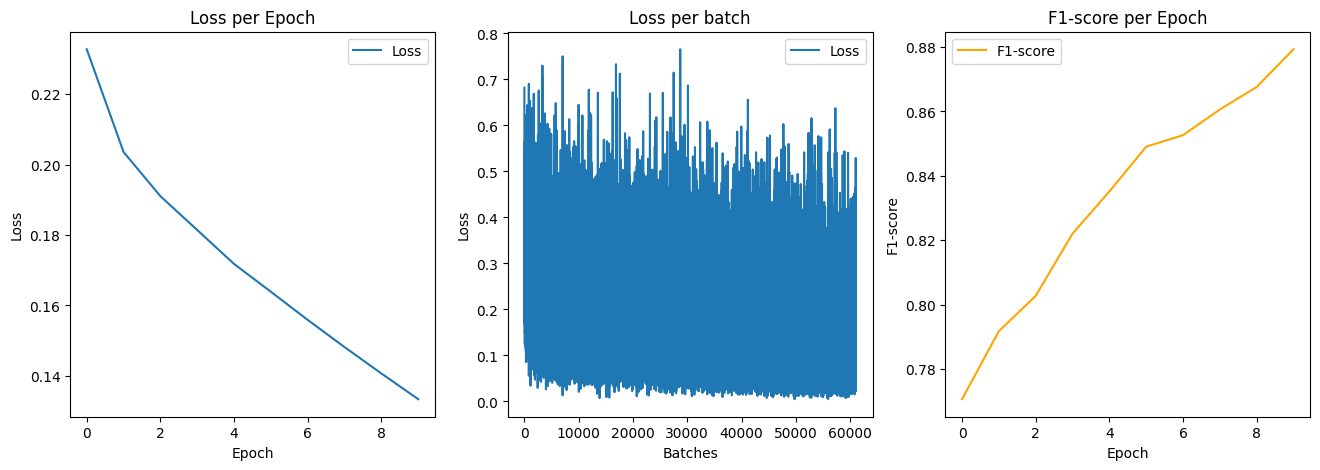

In [194]:
dropout_rate = 0.2
model = MyModel(dataloader, input_dim, output_dim, dropout_rate)
model.fit(lr=1e-3)
model.plot_metrics(X_test, y_test)

Epoch [1/10]; learning state	:   0%|          | 0/1527 [00:00<?, ?it/s]

Epoch [1/10]; metric state	: 100%|██████████| 1527/1527 [00:13<00:00, 111.90it/s]


Epoch [1/10], Loss: 0.2080, F1 score: 0.76523


Epoch [2/10]; metric state	: 100%|██████████| 1527/1527 [00:15<00:00, 101.75it/s]


Epoch [2/10], Loss: 0.1913, F1 score: 0.76922


Epoch [3/10]; metric state	: 100%|██████████| 1527/1527 [00:07<00:00, 213.98it/s]


Epoch [3/10], Loss: 0.2115, F1 score: 0.77631


Epoch [4/10]; metric state	: 100%|██████████| 1527/1527 [00:06<00:00, 220.53it/s]


Epoch [4/10], Loss: 0.2229, F1 score: 0.78436


Epoch [5/10]; metric state	: 100%|██████████| 1527/1527 [00:06<00:00, 222.37it/s]


Epoch [5/10], Loss: 0.1967, F1 score: 0.79378


Epoch [6/10]; metric state	: 100%|██████████| 1527/1527 [00:11<00:00, 137.04it/s]


Epoch [6/10], Loss: 0.1143, F1 score: 0.81222


Epoch [7/10]; metric state	: 100%|██████████| 1527/1527 [00:13<00:00, 111.75it/s]


Epoch [7/10], Loss: 0.3616, F1 score: 0.80833


Epoch [8/10]; metric state	: 100%|██████████| 1527/1527 [00:07<00:00, 207.30it/s]


Epoch [8/10], Loss: 0.1133, F1 score: 0.82935


Epoch [9/10]; metric state	: 100%|██████████| 1527/1527 [00:06<00:00, 222.75it/s]


Epoch [9/10], Loss: 0.2011, F1 score: 0.80520


Epoch [10/10]; metric state	: 100%|██████████| 1527/1527 [00:07<00:00, 216.03it/s]


Epoch [10/10], Loss: 0.0821, F1 score: 0.83406
F1 score on test tensors is: 80.19


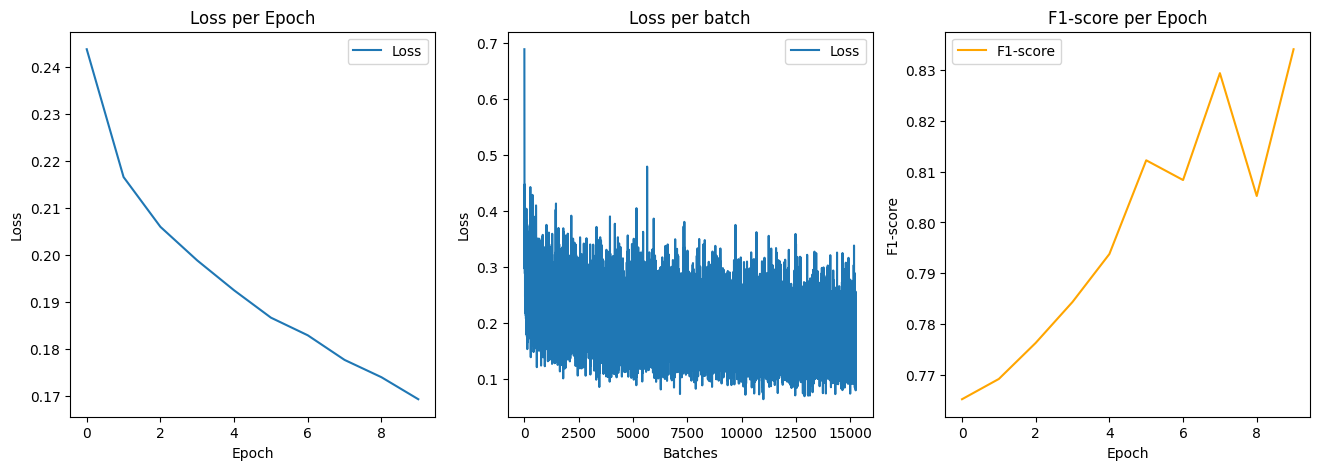

In [195]:
dropout_rate = 0.5
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)
model = MyModel(dataloader, input_dim, output_dim, dropout_rate)
model.fit(lr=1e-3)
model.plot_metrics(X_test, y_test)

Epoch [1/10]; metric state	: 100%|██████████| 382/382 [00:05<00:00, 71.84it/s]


Epoch [1/10], Loss: 0.2425, F1 score: 0.73260


Epoch [2/10]; metric state	: 100%|██████████| 382/382 [00:05<00:00, 74.64it/s]


Epoch [2/10], Loss: 0.1998, F1 score: 0.75625


Epoch [3/10]; metric state	: 100%|██████████| 382/382 [00:05<00:00, 72.67it/s]


Epoch [3/10], Loss: 0.1800, F1 score: 0.77075


Epoch [4/10]; metric state	: 100%|██████████| 382/382 [00:08<00:00, 44.82it/s]


Epoch [4/10], Loss: 0.2297, F1 score: 0.77225


Epoch [5/10]; metric state	: 100%|██████████| 382/382 [00:08<00:00, 44.92it/s]


Epoch [5/10], Loss: 0.2623, F1 score: 0.78507


Epoch [6/10]; metric state	: 100%|██████████| 382/382 [00:09<00:00, 41.22it/s]


Epoch [6/10], Loss: 0.1699, F1 score: 0.79389


Epoch [7/10]; metric state	: 100%|██████████| 382/382 [00:09<00:00, 41.02it/s]


Epoch [7/10], Loss: 0.2040, F1 score: 0.81502


Epoch [8/10]; metric state	: 100%|██████████| 382/382 [00:09<00:00, 40.52it/s]


Epoch [8/10], Loss: 0.1904, F1 score: 0.80571


Epoch [9/10]; metric state	: 100%|██████████| 382/382 [00:05<00:00, 74.90it/s]


Epoch [9/10], Loss: 0.1100, F1 score: 0.81543


Epoch [10/10]; metric state	: 100%|██████████| 382/382 [00:05<00:00, 70.88it/s]


Epoch [10/10], Loss: 0.1773, F1 score: 0.82699
F1 score on test tensors is: 79.77


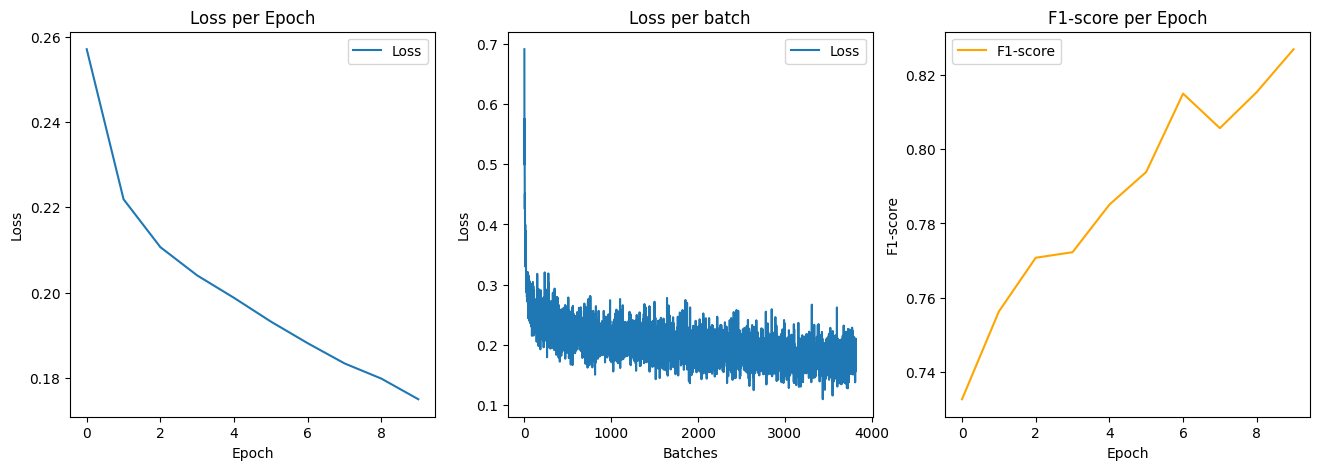

In [196]:
dropout_rate = 0.5
dataloader = DataLoader(dataset, batch_size=512, shuffle=True)
model = MyModel(dataloader, input_dim, output_dim, dropout_rate)
model.fit(lr=1e-3)
model.plot_metrics(X_test, y_test)

Epoch [1/25]; metric state	: 100%|██████████| 191/191 [00:04<00:00, 39.18it/s]


Epoch [1/25], Loss: 0.2311, F1 score: 0.73669


Epoch [2/25]; metric state	: 100%|██████████| 191/191 [00:04<00:00, 38.50it/s]


Epoch [2/25], Loss: 0.1950, F1 score: 0.75020


Epoch [3/25]; metric state	: 100%|██████████| 191/191 [00:04<00:00, 39.65it/s]


Epoch [3/25], Loss: 0.2267, F1 score: 0.78379


Epoch [4/25]; metric state	: 100%|██████████| 191/191 [00:04<00:00, 40.36it/s]


Epoch [4/25], Loss: 0.2209, F1 score: 0.79745


Epoch [5/25]; metric state	: 100%|██████████| 191/191 [00:05<00:00, 37.60it/s]


Epoch [5/25], Loss: 0.1834, F1 score: 0.79789


Epoch [6/25]; metric state	: 100%|██████████| 191/191 [00:05<00:00, 35.97it/s]


Epoch [6/25], Loss: 0.1814, F1 score: 0.81253


Epoch [7/25]; metric state	: 100%|██████████| 191/191 [00:04<00:00, 38.29it/s]


Epoch [7/25], Loss: 0.1812, F1 score: 0.81390


Epoch [8/25]; metric state	: 100%|██████████| 191/191 [00:05<00:00, 36.88it/s]


Epoch [8/25], Loss: 0.1965, F1 score: 0.82425


Epoch [9/25]; metric state	: 100%|██████████| 191/191 [00:04<00:00, 39.53it/s]


Epoch [9/25], Loss: 0.1714, F1 score: 0.82396


Epoch [10/25]; metric state	: 100%|██████████| 191/191 [00:04<00:00, 40.42it/s]


Epoch [10/25], Loss: 0.1416, F1 score: 0.84737


Epoch [11/25]; metric state	: 100%|██████████| 191/191 [00:04<00:00, 41.19it/s]


Epoch [11/25], Loss: 0.1748, F1 score: 0.85322


Epoch [12/25]; metric state	: 100%|██████████| 191/191 [00:05<00:00, 37.58it/s]


Epoch [12/25], Loss: 0.1385, F1 score: 0.84376


Epoch [13/25]; metric state	: 100%|██████████| 191/191 [00:04<00:00, 38.94it/s]


Epoch [13/25], Loss: 0.1834, F1 score: 0.86417


Epoch [14/25]; metric state	: 100%|██████████| 191/191 [00:04<00:00, 41.76it/s]


Epoch [14/25], Loss: 0.1593, F1 score: 0.87725


Epoch [15/25]; metric state	: 100%|██████████| 191/191 [00:04<00:00, 41.07it/s]


Epoch [15/25], Loss: 0.1392, F1 score: 0.87465


Epoch [16/25]; metric state	: 100%|██████████| 191/191 [00:04<00:00, 40.25it/s]


Epoch [16/25], Loss: 0.1282, F1 score: 0.88673


Epoch [17/25]; metric state	: 100%|██████████| 191/191 [00:04<00:00, 41.58it/s]


Epoch [17/25], Loss: 0.1894, F1 score: 0.89371


Epoch [18/25]; metric state	: 100%|██████████| 191/191 [00:04<00:00, 39.80it/s]


Epoch [18/25], Loss: 0.1220, F1 score: 0.89660


Epoch [19/25]; metric state	: 100%|██████████| 191/191 [00:04<00:00, 39.98it/s]


Epoch [19/25], Loss: 0.1219, F1 score: 0.89055


Epoch [20/25]; metric state	: 100%|██████████| 191/191 [00:05<00:00, 35.29it/s]


Epoch [20/25], Loss: 0.1118, F1 score: 0.91486


Epoch [21/25]; metric state	: 100%|██████████| 191/191 [00:04<00:00, 39.01it/s]


Epoch [21/25], Loss: 0.1079, F1 score: 0.91315


Epoch [22/25]; metric state	: 100%|██████████| 191/191 [00:04<00:00, 40.14it/s]


Epoch [22/25], Loss: 0.1257, F1 score: 0.92463


Epoch [23/25]; metric state	: 100%|██████████| 191/191 [00:04<00:00, 40.32it/s]


Epoch [23/25], Loss: 0.0748, F1 score: 0.91898


Epoch [24/25]; metric state	: 100%|██████████| 191/191 [00:04<00:00, 40.18it/s]


Epoch [24/25], Loss: 0.0945, F1 score: 0.93747


Epoch [25/25]; metric state	: 100%|██████████| 191/191 [00:05<00:00, 36.91it/s]


Epoch [25/25], Loss: 0.1247, F1 score: 0.93240
F1 score on test tensors is: 79.61


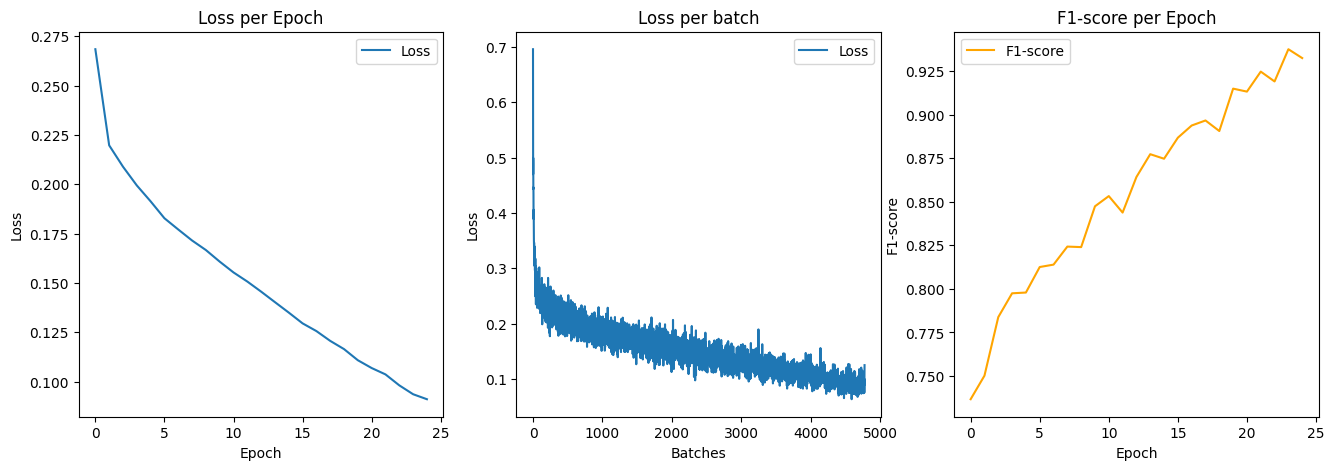

In [197]:
dropout_rate = 0.2
dataloader = DataLoader(dataset, batch_size=1024, shuffle=True)
model = MyModel(dataloader, input_dim, output_dim, dropout_rate)
model.fit(lr=1e-3, num_epoch=25)
model.plot_metrics(X_test, y_test)

Epoch [1/25]; metric state	: 100%|██████████| 96/96 [00:04<00:00, 20.99it/s]


Epoch [1/25], Loss: 0.2471, F1 score: 0.70798


Epoch [2/25]; metric state	: 100%|██████████| 96/96 [00:04<00:00, 20.68it/s]


Epoch [2/25], Loss: 0.2162, F1 score: 0.75386


Epoch [3/25]; metric state	: 100%|██████████| 96/96 [00:04<00:00, 21.68it/s]


Epoch [3/25], Loss: 0.2199, F1 score: 0.76989


Epoch [4/25]; metric state	: 100%|██████████| 96/96 [00:04<00:00, 21.75it/s]


Epoch [4/25], Loss: 0.2112, F1 score: 0.77979


Epoch [5/25]; metric state	: 100%|██████████| 96/96 [00:04<00:00, 21.30it/s]


Epoch [5/25], Loss: 0.1930, F1 score: 0.78291


Epoch [6/25]; metric state	: 100%|██████████| 96/96 [00:04<00:00, 21.54it/s]


Epoch [6/25], Loss: 0.2176, F1 score: 0.78199


Epoch [7/25]; metric state	: 100%|██████████| 96/96 [00:04<00:00, 20.98it/s]


Epoch [7/25], Loss: 0.2177, F1 score: 0.79897


Epoch [8/25]; metric state	: 100%|██████████| 96/96 [00:04<00:00, 21.36it/s]


Epoch [8/25], Loss: 0.1651, F1 score: 0.80329


Epoch [9/25]; metric state	: 100%|██████████| 96/96 [00:04<00:00, 20.83it/s]


Epoch [9/25], Loss: 0.1969, F1 score: 0.80831


Epoch [10/25]; metric state	: 100%|██████████| 96/96 [00:04<00:00, 21.64it/s]


Epoch [10/25], Loss: 0.2190, F1 score: 0.81835


Epoch [11/25]; metric state	: 100%|██████████| 96/96 [00:04<00:00, 21.60it/s]


Epoch [11/25], Loss: 0.1870, F1 score: 0.81535


Epoch [12/25]; metric state	: 100%|██████████| 96/96 [00:04<00:00, 21.38it/s]


Epoch [12/25], Loss: 0.1546, F1 score: 0.82751


Epoch [13/25]; metric state	: 100%|██████████| 96/96 [00:04<00:00, 20.86it/s]


Epoch [13/25], Loss: 0.1413, F1 score: 0.83633


Epoch [14/25]; metric state	: 100%|██████████| 96/96 [00:04<00:00, 21.33it/s]


Epoch [14/25], Loss: 0.1763, F1 score: 0.83236


Epoch [15/25]; metric state	: 100%|██████████| 96/96 [00:04<00:00, 21.40it/s]


Epoch [15/25], Loss: 0.1428, F1 score: 0.84666


Epoch [16/25]; metric state	: 100%|██████████| 96/96 [00:04<00:00, 19.83it/s]


Epoch [16/25], Loss: 0.1454, F1 score: 0.85033


Epoch [17/25]; metric state	: 100%|██████████| 96/96 [00:04<00:00, 20.52it/s]


Epoch [17/25], Loss: 0.1567, F1 score: 0.85661


Epoch [18/25]; metric state	: 100%|██████████| 96/96 [00:04<00:00, 21.11it/s]


Epoch [18/25], Loss: 0.1467, F1 score: 0.86457


Epoch [19/25]; metric state	: 100%|██████████| 96/96 [00:04<00:00, 21.05it/s]


Epoch [19/25], Loss: 0.1741, F1 score: 0.86933


Epoch [20/25]; metric state	: 100%|██████████| 96/96 [00:04<00:00, 21.17it/s]


Epoch [20/25], Loss: 0.1530, F1 score: 0.86885


Epoch [21/25]; metric state	: 100%|██████████| 96/96 [00:04<00:00, 21.31it/s]


Epoch [21/25], Loss: 0.1380, F1 score: 0.88166


Epoch [22/25]; metric state	: 100%|██████████| 96/96 [00:04<00:00, 20.14it/s]


Epoch [22/25], Loss: 0.1437, F1 score: 0.88527


Epoch [23/25]; metric state	: 100%|██████████| 96/96 [00:04<00:00, 21.22it/s]


Epoch [23/25], Loss: 0.1190, F1 score: 0.89162


Epoch [24/25]; metric state	: 100%|██████████| 96/96 [00:04<00:00, 21.35it/s]


Epoch [24/25], Loss: 0.1190, F1 score: 0.89777


Epoch [25/25]; metric state	: 100%|██████████| 96/96 [00:04<00:00, 21.25it/s]


Epoch [25/25], Loss: 0.1373, F1 score: 0.90177
F1 score on test tensors is: 79.48


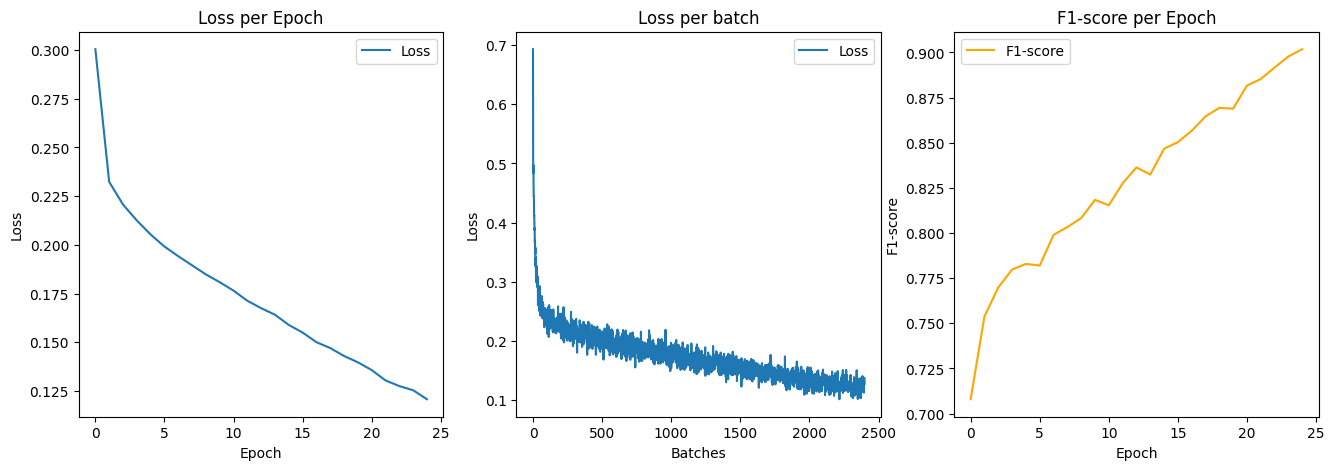

In [198]:
dropout_rate = 0.2
dataloader = DataLoader(dataset, batch_size=2048, shuffle=True)
model = MyModel(dataloader, input_dim, output_dim, dropout_rate)
model.fit(lr=1e-3, num_epoch=25)
model.plot_metrics(X_test, y_test)

Epoch [1/50]; metric state	: 100%|██████████| 191/191 [00:04<00:00, 40.47it/s]


Epoch [1/50], Loss: 0.2144, F1 score: 0.75072


Epoch [2/50]; metric state	: 100%|██████████| 191/191 [00:04<00:00, 40.09it/s]


Epoch [2/50], Loss: 0.2162, F1 score: 0.77449


Epoch [3/50]; metric state	: 100%|██████████| 191/191 [00:04<00:00, 39.61it/s]


Epoch [3/50], Loss: 0.1846, F1 score: 0.78493


Epoch [4/50]; metric state	: 100%|██████████| 191/191 [00:04<00:00, 40.87it/s]


Epoch [4/50], Loss: 0.2133, F1 score: 0.79283


Epoch [5/50]; metric state	: 100%|██████████| 191/191 [00:04<00:00, 41.37it/s]


Epoch [5/50], Loss: 0.2242, F1 score: 0.80801


Epoch [6/50]; metric state	: 100%|██████████| 191/191 [00:04<00:00, 41.93it/s]


Epoch [6/50], Loss: 0.2051, F1 score: 0.80893


Epoch [7/50]; metric state	: 100%|██████████| 191/191 [00:04<00:00, 41.85it/s]


Epoch [7/50], Loss: 0.1491, F1 score: 0.81192


Epoch [8/50]; metric state	: 100%|██████████| 191/191 [00:04<00:00, 39.58it/s]


Epoch [8/50], Loss: 0.1820, F1 score: 0.81394


Epoch [9/50]; metric state	: 100%|██████████| 191/191 [00:04<00:00, 42.07it/s]


Epoch [9/50], Loss: 0.1737, F1 score: 0.83641


Epoch [10/50]; metric state	: 100%|██████████| 191/191 [00:05<00:00, 36.20it/s]


Epoch [10/50], Loss: 0.1548, F1 score: 0.83088


Epoch [11/50]; metric state	: 100%|██████████| 191/191 [00:04<00:00, 40.52it/s]


Epoch [11/50], Loss: 0.1657, F1 score: 0.85463


Epoch [12/50]; metric state	: 100%|██████████| 191/191 [00:04<00:00, 42.03it/s]


Epoch [12/50], Loss: 0.1276, F1 score: 0.85890


Epoch [13/50]; metric state	: 100%|██████████| 191/191 [00:05<00:00, 35.57it/s]


Epoch [13/50], Loss: 0.1382, F1 score: 0.86574


Epoch [14/50]; metric state	: 100%|██████████| 191/191 [00:05<00:00, 36.78it/s]


Epoch [14/50], Loss: 0.1292, F1 score: 0.87448


Epoch [15/50]; metric state	: 100%|██████████| 191/191 [00:04<00:00, 40.89it/s]


Epoch [15/50], Loss: 0.1124, F1 score: 0.87390


Epoch [16/50]; metric state	: 100%|██████████| 191/191 [00:04<00:00, 41.56it/s]


Epoch [16/50], Loss: 0.1278, F1 score: 0.89047


Epoch [17/50]; metric state	: 100%|██████████| 191/191 [00:04<00:00, 42.08it/s]


Epoch [17/50], Loss: 0.1412, F1 score: 0.89022


Epoch [18/50]; metric state	: 100%|██████████| 191/191 [00:05<00:00, 36.54it/s]


Epoch [18/50], Loss: 0.1149, F1 score: 0.89768


Epoch [19/50]; metric state	: 100%|██████████| 191/191 [00:04<00:00, 41.81it/s]


Epoch [19/50], Loss: 0.1252, F1 score: 0.90620


Epoch [20/50]; metric state	: 100%|██████████| 191/191 [00:04<00:00, 42.41it/s]


Epoch [20/50], Loss: 0.1319, F1 score: 0.90716


Epoch [21/50]; metric state	: 100%|██████████| 191/191 [00:04<00:00, 42.48it/s]


Epoch [21/50], Loss: 0.1226, F1 score: 0.90538


Epoch [22/50]; metric state	: 100%|██████████| 191/191 [00:04<00:00, 42.52it/s]


Epoch [22/50], Loss: 0.0983, F1 score: 0.92040


Epoch [23/50]; metric state	: 100%|██████████| 191/191 [00:04<00:00, 42.53it/s]


Epoch [23/50], Loss: 0.0855, F1 score: 0.93019


Epoch [24/50]; metric state	: 100%|██████████| 191/191 [00:04<00:00, 41.29it/s]


Epoch [24/50], Loss: 0.0917, F1 score: 0.93112


Epoch [25/50]; metric state	: 100%|██████████| 191/191 [00:04<00:00, 40.05it/s]


Epoch [25/50], Loss: 0.0893, F1 score: 0.93815


Epoch [26/50]; metric state	: 100%|██████████| 191/191 [00:04<00:00, 40.12it/s]


Epoch [26/50], Loss: 0.0837, F1 score: 0.94062


Epoch [27/50]; metric state	: 100%|██████████| 191/191 [00:04<00:00, 39.51it/s]


Epoch [27/50], Loss: 0.0746, F1 score: 0.94213


Epoch [28/50]; metric state	: 100%|██████████| 191/191 [00:04<00:00, 40.15it/s]


Epoch [28/50], Loss: 0.1036, F1 score: 0.95302


Epoch [29/50]; metric state	: 100%|██████████| 191/191 [00:04<00:00, 39.56it/s]


Epoch [29/50], Loss: 0.0869, F1 score: 0.95100


Epoch [30/50]; metric state	: 100%|██████████| 191/191 [00:04<00:00, 39.01it/s]


Epoch [30/50], Loss: 0.0760, F1 score: 0.96163


Epoch [31/50]; metric state	: 100%|██████████| 191/191 [00:04<00:00, 41.12it/s]


Epoch [31/50], Loss: 0.0709, F1 score: 0.96154


Epoch [32/50]; metric state	: 100%|██████████| 191/191 [00:04<00:00, 40.85it/s]


Epoch [32/50], Loss: 0.0719, F1 score: 0.95928


Epoch [33/50]; metric state	: 100%|██████████| 191/191 [00:04<00:00, 40.75it/s]


Epoch [33/50], Loss: 0.0772, F1 score: 0.95020


Epoch [34/50]; metric state	: 100%|██████████| 191/191 [00:04<00:00, 38.97it/s]


Epoch [34/50], Loss: 0.0633, F1 score: 0.96967


Epoch [35/50]; metric state	: 100%|██████████| 191/191 [00:05<00:00, 35.16it/s]


Epoch [35/50], Loss: 0.0666, F1 score: 0.97348


Epoch [36/50]; metric state	: 100%|██████████| 191/191 [00:05<00:00, 36.84it/s]


Epoch [36/50], Loss: 0.0699, F1 score: 0.97301


Epoch [37/50]; metric state	: 100%|██████████| 191/191 [00:04<00:00, 40.49it/s]


Epoch [37/50], Loss: 0.0609, F1 score: 0.97618


Epoch [38/50]; metric state	: 100%|██████████| 191/191 [00:04<00:00, 39.25it/s]


Epoch [38/50], Loss: 0.0542, F1 score: 0.97659


Epoch [39/50]; metric state	: 100%|██████████| 191/191 [00:04<00:00, 40.87it/s]


Epoch [39/50], Loss: 0.0493, F1 score: 0.97585


Epoch [40/50]; metric state	: 100%|██████████| 191/191 [00:05<00:00, 38.09it/s]


Epoch [40/50], Loss: 0.0475, F1 score: 0.98222


Epoch [41/50]; metric state	: 100%|██████████| 191/191 [00:05<00:00, 37.11it/s]


Epoch [41/50], Loss: 0.0428, F1 score: 0.98509


Epoch [42/50]; metric state	: 100%|██████████| 191/191 [00:05<00:00, 35.40it/s]


Epoch [42/50], Loss: 0.0558, F1 score: 0.98542


Epoch [43/50]; metric state	: 100%|██████████| 191/191 [00:05<00:00, 37.98it/s]


Epoch [43/50], Loss: 0.0390, F1 score: 0.98687


Epoch [44/50]; metric state	: 100%|██████████| 191/191 [00:05<00:00, 37.49it/s]


Epoch [44/50], Loss: 0.0397, F1 score: 0.98679


Epoch [45/50]; metric state	: 100%|██████████| 191/191 [00:04<00:00, 38.53it/s]


Epoch [45/50], Loss: 0.0484, F1 score: 0.98354


Epoch [46/50]; metric state	: 100%|██████████| 191/191 [00:04<00:00, 40.08it/s]


Epoch [46/50], Loss: 0.0453, F1 score: 0.98817


Epoch [47/50]; metric state	: 100%|██████████| 191/191 [00:05<00:00, 37.91it/s]


Epoch [47/50], Loss: 0.0457, F1 score: 0.98409


Epoch [48/50]; metric state	: 100%|██████████| 191/191 [00:04<00:00, 40.23it/s]


Epoch [48/50], Loss: 0.0570, F1 score: 0.98913


Epoch [49/50]; metric state	: 100%|██████████| 191/191 [00:04<00:00, 40.05it/s]


Epoch [49/50], Loss: 0.0502, F1 score: 0.98905


Epoch [50/50]; metric state	: 100%|██████████| 191/191 [00:04<00:00, 38.97it/s]


Epoch [50/50], Loss: 0.0399, F1 score: 0.99213
F1 score on test tensors is: 78.88


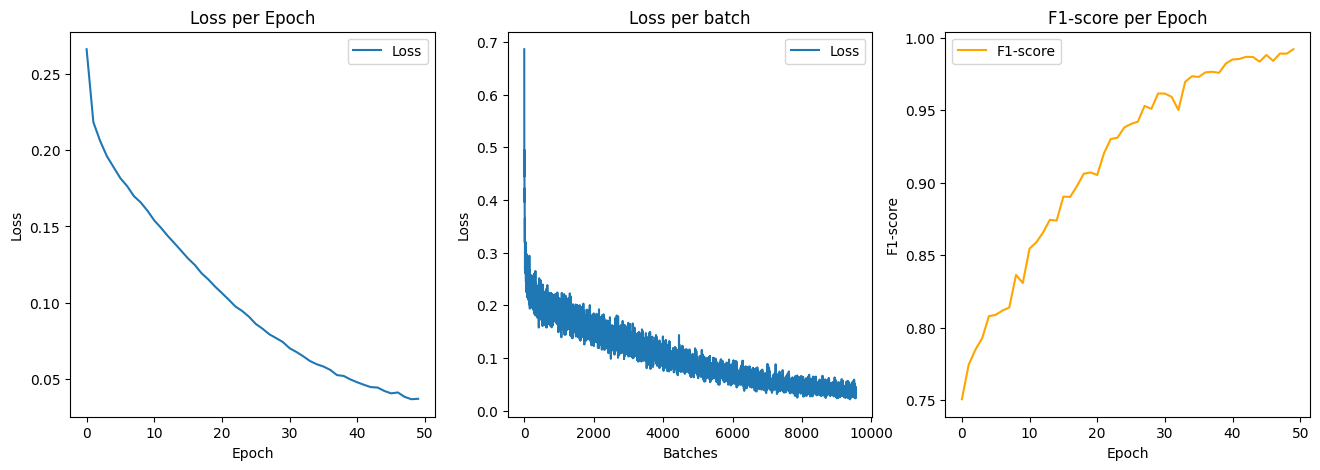

In [202]:
dropout_rate = 0.2
dataloader = DataLoader(dataset, batch_size=1024, shuffle=True)
model = MyModel(dataloader, input_dim, output_dim, dropout_rate)
model.fit(lr=1e-3, num_epoch=50)
model.plot_metrics(X_test, y_test)

In [205]:
tokenizer = BertTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")
embedding_model = BertModel.from_pretrained("DeepPavlov/rubert-base-cased")
def text_to_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = embedding_model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [233]:
def check_ur_comment(comment:str):
    my_comment_embedding = text_to_embedding(comment)
    my_comment_tensor = torch.tensor(my_comment_embedding, dtype=torch.float32)
    model.eval()
    with torch.no_grad():
        preds = model(my_comment_tensor.unsqueeze(0).to(device))
    preds_squeezed = preds.squeeze(1).squeeze(1)
    return round(preds_squeezed.item()*100,2)

In [236]:
check_ur_comment("идиот и долбаеб")

99.97

In [237]:
check_ur_comment("красавчик")

0.0

In [252]:
check_ur_comment("ты не прав, иди учи базу")

10.96

In [249]:
check_ur_comment("красивый идиот")

89.83

In [248]:
check_ur_comment("сказочный долбаеб")

99.99

In [254]:
check_ur_comment("тупорылая работа")

58.69